In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split

In [2]:
#membaca dataset delhiweather.csv
df = pd.read_csv('delhiweather.csv')
df.shape
#pada data set ini terdapat 100990 data dengan kolom sebanyak 20

(95505, 20)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95505 entries, 0 to 95504
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   datetime_utc  95505 non-null  object 
 1    _conds       95441 non-null  object 
 2    _dewptm      94893 non-null  float64
 3    _fog         95505 non-null  int64  
 4    _hail        95505 non-null  int64  
 5    _heatindexm  27430 non-null  float64
 6    _hum         94764 non-null  float64
 7    _precipm     0 non-null      float64
 8    _pressurem   95284 non-null  float64
 9    _rain        95504 non-null  float64
 10   _snow        95504 non-null  float64
 11   _tempm       94847 non-null  float64
 12   _thunder     95504 non-null  float64
 13   _tornado     95504 non-null  float64
 14   _vism        91132 non-null  float64
 15   _wdird       81598 non-null  float64
 16   _wdire       81598 non-null  object 
 17   _wgustm      1051 non-null   float64
 18   _windchillm  573 non-null

In [4]:
df.head(10)

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0.0,0.0,30.0,0.0,0.0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0.0,0.0,28.0,0.0,0.0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0.0,0.0,24.0,0.0,0.0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0.0,0.0,24.0,0.0,0.0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0.0,0.0,23.0,0.0,0.0,1.2,0.0,North,NaN,NaN,0.0
5,19961101-17:00,Smoke,12.0,0,0,NaN,56.0,NaN,1011.0,0.0,0.0,21.0,0.0,0.0,NaN,0.0,North,NaN,NaN,NaN
6,19961101-18:00,Smoke,13.0,0,0,NaN,60.0,NaN,1010.0,0.0,0.0,21.0,0.0,0.0,0.8,0.0,North,NaN,NaN,0.0
7,19961101-19:00,Smoke,13.0,0,0,NaN,60.0,NaN,-9999.0,0.0,0.0,21.0,0.0,0.0,NaN,0.0,North,NaN,NaN,NaN
8,19961101-20:00,Smoke,13.0,0,0,NaN,68.0,NaN,-9999.0,0.0,0.0,19.0,0.0,0.0,NaN,0.0,North,NaN,NaN,NaN
9,19961101-21:00,Smoke,13.0,0,0,NaN,68.0,NaN,1010.0,0.0,0.0,19.0,0.0,0.0,NaN,0.0,North,NaN,NaN,NaN


In [5]:
#mengecek apakah ada nilai yang hilang dr dataset
df.isnull().sum()

datetime_utc        0
 _conds            64
 _dewptm          612
 _fog               0
 _hail              0
 _heatindexm    68075
 _hum             741
 _precipm       95505
 _pressurem       221
 _rain              1
 _snow              1
 _tempm           658
 _thunder           1
 _tornado           1
 _vism           4373
 _wdird         13907
 _wdire         13907
 _wgustm        94454
 _windchillm    94932
 _wspdm          2318
dtype: int64

In [6]:
df['datetime_utc']=pd.to_datetime(df['datetime_utc'])
df['datetime_utc'].head()
df[' _tempm'].fillna(df[' _tempm'].mean(), inplace=True) 
df = df[['datetime_utc',' _tempm' ]]
df.head(10)

,datetime_utc,_tempm
0,1996-11-01 11:00:00,30.0
1,1996-11-01 12:00:00,28.0
2,1996-11-01 13:00:00,24.0
3,1996-11-01 14:00:00,24.0
4,1996-11-01 16:00:00,23.0
5,1996-11-01 17:00:00,21.0
6,1996-11-01 18:00:00,21.0
7,1996-11-01 19:00:00,21.0
8,1996-11-01 20:00:00,19.0
9,1996-11-01 21:00:00,19.0


In [7]:
#mengubah kolom datatime_utc menjadi date dan dibuat df baru bernama delhinew
delhi=df[['datetime_utc',' _tempm']].copy()
delhi['date'] = delhi['datetime_utc'].dt.date
delhinew=delhi.drop('datetime_utc',axis=1)
delhinew.set_index('date', inplace= True)
delhinew.head(10)

,_tempm
date,
1996-11-01,30.0
1996-11-01,28.0
1996-11-01,24.0
1996-11-01,24.0
1996-11-01,23.0
1996-11-01,21.0
1996-11-01,21.0
1996-11-01,21.0
1996-11-01,19.0


In [8]:
delhinew.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95505 entries, 1996-11-01 to 2016-06-23
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0    _tempm  95505 non-null  float64
dtypes: float64(1)
memory usage: 1.5+ MB


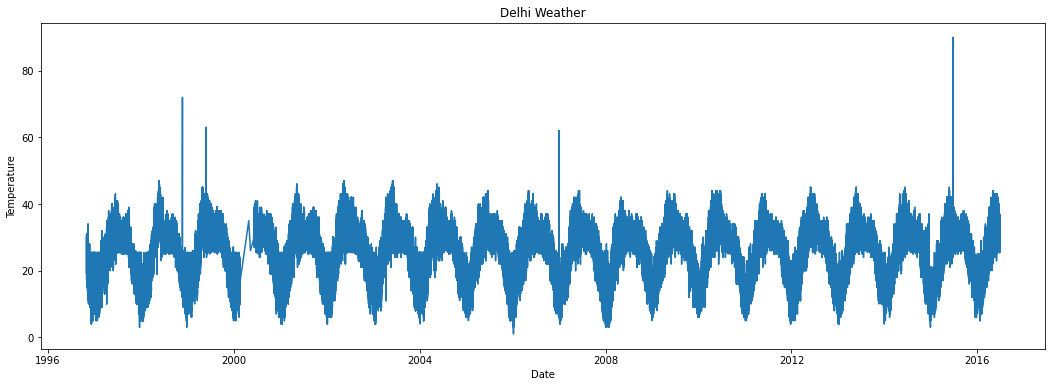

In [9]:
#membuat plot dari data delhi weather
date = delhi['date'].values
temp = delhi[' _tempm'].values

plt.figure(figsize=(18,6))
plt.plot(delhinew)
plt.title('Delhi Weather')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

In [10]:
#menerima sebuah atribut yg telah dikonversi menjadi tipe numpy,lalu mengembalikan label dan atribut dari dataset dalam bentuk batch
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [11]:
#split data dimana validation setnya 20% dari dataset
x_train, x_test, y_train, y_test = train_test_split(temp, date, test_size = 0.2, random_state = 0 , shuffle=False)
#mengetahui ukuran x_train dan x_test
print(len(x_train), len(x_test))

76404 19101


In [12]:
# model
data_x_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

#Optimizer menggunakan Learning Rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [13]:
max = df[' _tempm'].max()
print('Max value: ' )
print(max)
min = df[' _tempm'].min()
print('Min Value: ')
print(min)

Max value: 
90.0
Min Value: 
1.0


In [14]:
x = (max - min) * (10 / 100)
print(x)

8.9


In [15]:
# callback
class CallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< x):
      self.model.stop_training = True
      print('\nFor Epoch', epoch, ' training has been stopped.''\n Because MAE of the model has reach < 10% of data scale')
callbacks = CallBack()

In [16]:
tf.keras.backend.set_floatx('float64')
history = model.fit(data_x_train ,epochs=100, validation_data=data_x_test, callbacks=[callbacks])

Epoch 1/100
764/764 [==============================] - 32s 32ms/step - loss: 24.0703 - mae: 24.5651 - val_loss: 16.2618 - val_mae: 16.7537
Epoch 2/100
764/764 [==============================] - 25s 31ms/step - loss: 11.9277 - mae: 12.4162 - val_loss: 8.9130 - val_mae: 9.3981
Epoch 3/100
764/764 [==============================] - 24s 31ms/step - loss: 6.8176 - mae: 7.2983 - val_loss: 5.9739 - val_mae: 6.4541

For Epoch 2  training has been stopped.
 Because MAE of the model has reach < 10% of data scale


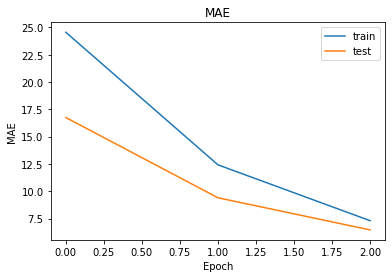

In [17]:
# plot of mean absolute error
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

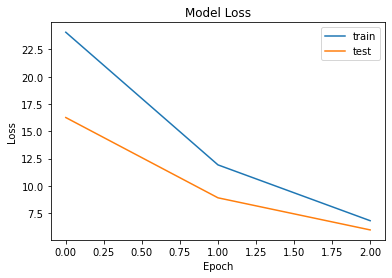

In [18]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()